# Import libraries

In [1]:
import os
import sys
import statistics
import numpy as np
import pandas as pd
from collections import namedtuple
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Configuration

Configure properties that will be used for the machine learning model and regression tests

Edit these as needed before running the notebook

In [2]:
# The proportion of the dataset that should be used for training the model (out of 1.0)
proportion_train_data = 0.75

# The number of trials that should be conducted per regression; each trial uses a randomly-generated training dataset
number_of_trials = 10

# The file path where the combined dataset CSV is located
file_path = "C:/Users/jmmen/Documents/datasets"

# The name of the Combined Data CSV file
file_name = "combine_data_with_labels_new.csv"

# Functions

Define function that will be used for generating summary statistics and performing regression analysis

In [3]:
# (DataFrame df, String dependent_var, String[] independent_vars)
def dataframe_summary_statistics(df, independent_vars):    
    # Plot correlation heatmap
    corr = df[independent_vars].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(250, 20, as_cmap=True)
    plt.subplots(figsize=(15, 15))    
    
    # Return formatted plot
    hm = sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=1.0, vmin=-1.0, center=0, square=False, linewidths=.3, cbar_kws={"shrink": .8})
    hm.figure.tight_layout()
    hm.figure.subplots_adjust(bottom = 0.25)
    return hm, plt;

In [4]:
# (DataFrame df, String dependent_var, String[] independent_vars, Double proportion_test_data, Integer number_of_trials)
def perform_ml_regression(df_raw, dependent_var, independent_vars, proportion_test_data, number_of_trials):
    # Multiple Regression ML train and test; X = Independent Variables, Y = Dependent Variable
    all_vars = independent_vars.copy()
    all_vars.append(dependent_var)
    
    # Fill any missing values with the mean (there should be very few)
    df = df_raw[all_vars].copy()
    df = df.fillna(df.mean())
    
    X = df[independent_vars]
    X = sm.add_constant(X)
    Y = df[dependent_var]
    sqrt_mse_arr = []
    r2_arr = []
    pval_arr = []
    coef_arr = []
    vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index = X.columns)
    
    # Iterate equal to number of trials
    for x in range(1, number_of_trials + 1):
        # Split dataset into training and test data
        x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = proportion_train_data)
        
        # Fit the OLS regression model using the training datasets (Ordinary Least Squares Linear Regression algorithm)
        mreg = sm.OLS(endog = y_train, exog = x_train, missing = 'drop').fit()
        
        # Test the OLS model with the test datasets
        test_results = mreg.predict(x_test)
        sqrt_mse = np.sqrt(mean_squared_error(y_test, test_results))
        r2 = r2_score(y_test, test_results)
        print("Trial ", x, "OLS; Square-Root of MSE: ", sqrt_mse, "; R-Squared:", r2)
        
        sqrt_mse_arr.append(sqrt_mse)
        r2_arr.append(r2)
        pval_arr.append(mreg.pvalues.sort_values())
        coef_arr.append(pd.Series(mreg.params, index = X.columns))
        
    sum_coefs = pd.concat(coef_arr, axis=1, sort=False).sum(axis=1).divide(number_of_trials).sort_values(ascending = False)
    sum_pvals = pd.concat(pval_arr, axis=1, sort=False).sum(axis=1).divide(number_of_trials).sort_values(ascending = True)
    
    regression_results = namedtuple("regression_results", "sqrt_mse_arr r2_arr pval_arr vif coef")
    return regression_results(sqrt_mse_arr, r2_arr, sum_pvals, vif, sum_coefs)

# Pre-Process Data

Import the dataframe

In [5]:
try:
    os.chdir(file_path)
except:
    sys.exit("Unable to reach default path. Aborting")
print("Current Path: " + os.getcwd())
print("Reading file: ", "combine_data.csv")
wd_combined_init = pd.read_csv(file_name, sep=",", dtype=('str'))

Current Path: C:\Users\jmmen\Documents\datasets
Reading file:  combine_data.csv


In [6]:
print(wd_combined_init.columns)

Index(['DayOfWeek', 'FlightDate', 'Carrier', 'DepAirportID', 'DepStateAbr',
       'CRSDepTime', 'ActualDepTime', 'DepDelay', 'DepDelayNew', 'Cancelled',
       'WeatherDelay', 'WeatherDate', 'HourlyAltimeterSetting',
       'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity',
       'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility',
       'HourlyWetBulbTemperature', 'HourlyWindSpeed', 'Label1', 'Label2',
       'Label3'],
      dtype='object')


Select only relevent columns from the DataFrame 

These are the columns that can/will be used Independent Variables in the model

In [7]:
wd_combined = wd_combined_init.copy() 
wd_combined = wd_combined[['FlightDate', 'Carrier',
       'DepAirportID', 'CRSDepTime', 'ActualDepTime', 'DepDelay', 'DepDelayNew', 
       'Cancelled', 'WeatherDelay', 'WeatherDate', 
       'HourlyAltimeterSetting', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
       'HourlyPrecipitation', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 
       'HourlyStationPressure', 'HourlyVisibility', 
       'HourlyWetBulbTemperature', 'HourlyWindSpeed']]

Select only records where WeatherDelay is not null

In [8]:
wd_combined = wd_combined[wd_combined["WeatherDelay"].notna()]
wd_combined["WeatherDelay"] = wd_combined["WeatherDelay"].astype(float)

Copy dataframe and reset index

In [9]:
wd_weather = wd_combined.copy()
wd_weather.reset_index(drop=True, inplace=True)
pd.set_option('display.max_columns', 20)

Now that the dataframe has been created and prepared, we perform the first iteration of variable selection tests, with all possible independent variables included in the multiple regression model

In [10]:
%config InlineBackend.close_figures=False
plt.ioff()

# Variable Selection Iteration 1

In [11]:
independent_var_list = ["HourlyAltimeterSetting","HourlyDewPointTemperature",
                     "HourlyDryBulbTemperature","HourlyPrecipitation",
                     "HourlyRelativeHumidity","HourlySeaLevelPressure",
                     "HourlyStationPressure","HourlyVisibility",
                     "HourlyWetBulbTemperature","HourlyWindSpeed"]
# Assign all IV columns to float type
for var in independent_var_list:
    wd_weather[var] = wd_weather[var].astype(float)

In [12]:
heat_map1, plot1 = dataframe_summary_statistics(wd_weather, independent_var_list)
regression_results1 = perform_ml_regression(wd_weather, "WeatherDelay", independent_var_list, proportion_train_data, number_of_trials)
plot1.ioff();

Trial  1 OLS; Square-Root of MSE:  15.876165937258602 ; R-Squared: 0.029443274344988057
Trial  2 OLS; Square-Root of MSE:  16.10336670454099 ; R-Squared: 0.02773142960923536
Trial  3 OLS; Square-Root of MSE:  16.271682598491797 ; R-Squared: 0.02523931450695238
Trial  4 OLS; Square-Root of MSE:  16.469215036895378 ; R-Squared: 0.027603826679165278
Trial  5 OLS; Square-Root of MSE:  15.9672031727156 ; R-Squared: 0.025603535393226462
Trial  6 OLS; Square-Root of MSE:  15.585156460093174 ; R-Squared: 0.027859527535780915
Trial  7 OLS; Square-Root of MSE:  16.7361279223298 ; R-Squared: 0.027128923422837237
Trial  8 OLS; Square-Root of MSE:  16.25841648792196 ; R-Squared: 0.02561602196160906
Trial  9 OLS; Square-Root of MSE:  15.979495681412867 ; R-Squared: 0.026736087095758365
Trial  10 OLS; Square-Root of MSE:  16.30406589099466 ; R-Squared: 0.024103402463621748


## Iteration 1 Results

### Average Square-Root of Mean-Squared-Error (MSE) and R-Squared:

The Square-Root of the Mean-Squared Error represents the average amount of error of any given prediction by this model. In this case, that would be the average number of minutes that the prediction would be off by. 

For example, if the SQ-MSE is 14.0, and the model predicts a delay time of 60 minutes, on average the actual delay time will be between 46 - 74 minutes (plus or minus 14.0 from the predicted delay)

The R-Squared value measures the proportion of the variance of the dependent variable that can be explained by changes to the independent variables. It can range from 0.0 to 1.0, with higher values meaning a greater correlation. A low R-Squared value could mean that there is a minimal correlation between the IVs and DV, but it could also just indicate noisy data. To determiner which is the case, we will need to examine the P-Values of each IV as well.

In [13]:
print("Average SQ-MSE across", number_of_trials, "trials:", statistics.mean(regression_results1.sqrt_mse_arr))

Average SQ-MSE across 10 trials: 16.155089589265483


In [14]:
print("Average R-Squared across", number_of_trials, "trials:", statistics.mean(regression_results1.r2_arr))

Average R-Squared across 10 trials: 0.026706534301317485


### Average P-Values across all trials:

This number represents the statistical significance of the correlation between each Independent Variable and the Dependent Variable (Weather Delay, in minutes). Smaller P-Values indicate a more statistically-significant correlation.

P-Values aren't as accurate in a multiple regression model than they are in a single variable linear regression model, but they still provided a good general idea of which variables are worth using in our model.

In [15]:
print("Average P-Values:\n")
print(regression_results1.pval_arr.to_string())

Average P-Values:

HourlyPrecipitation           0.000000e+00
HourlyWindSpeed              4.763583e-195
HourlyVisibility              6.572041e-82
const                         1.299509e-26
HourlyStationPressure         3.379738e-21
HourlyRelativeHumidity        3.538488e-20
HourlyDewPointTemperature     7.656027e-03
HourlyWetBulbTemperature      5.648651e-02
HourlyAltimeterSetting        2.622496e-01
HourlySeaLevelPressure        3.707614e-01
HourlyDryBulbTemperature      6.110449e-01


### Correlation plot and Variation Inflation Factors (VAF) of all Independent Variables:

Overly-correlated Independent Variables can result in an artificially-inflated R-squared value, and can cause us to incorrectly reject the null hypothesis. It can also lead to inaccurate correlation coefficient values, and can cause other irregularities such as overfitting in the data, making the model less flexible. 

This is because the main purpose of any regression analysis is to determine the correlation between each IV and the DV. The coefficient assigned to each IV represents the amount and magnitude of change to the DV that should, on average, result from a single unit increase in that specific IV. If IVs are too highly correlated, the independence assumption is not met, and it becomes harder for the model to identify what changes to the DV are associated with each IV. 

The Correlation plot and Variation Inflation Factors (VIF) above are both measures of the multicollinearity between Independent variables used in the model. The correlation plot shows the degree and direction of correlation between each pair of IVs, ranging from -1.0 (full negative correlation, where increase in x results in a proportional decrease in y) to 1.0 (full positive correlation, where increase in x results in a proportional increase in y). 

VIF is a measure of the strength of each Independent Variable's multicollinearity with all other IVs. A value of 1.0 indicates no correlation, while a VIF greater than 5.0 is typically viewed as a severe level of correlation that should be addressed.

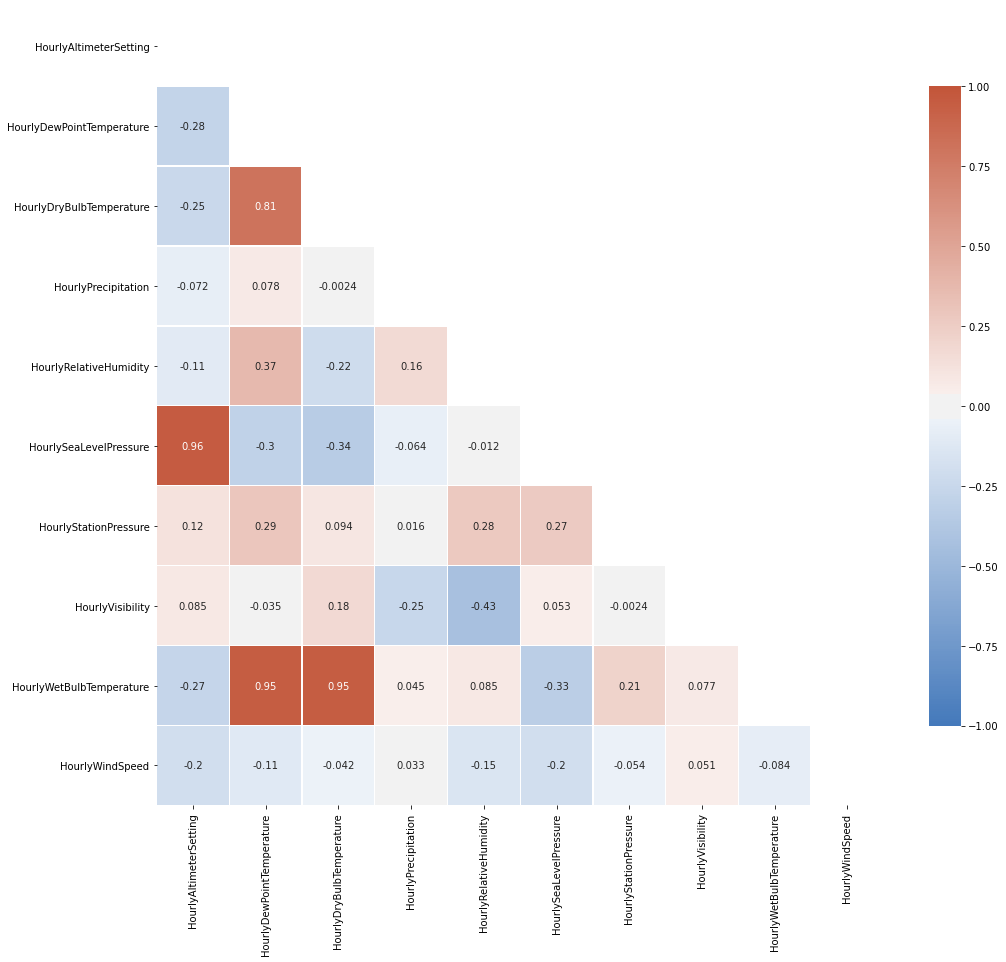

In [16]:
plot1.show()

In [17]:
print(regression_results1.vif.sort_values(ascending = True).to_string())

HourlyPrecipitation              1.086414
HourlyWindSpeed                  1.117973
HourlyVisibility                 1.459662
HourlyStationPressure            2.044170
HourlyRelativeHumidity          19.446610
HourlyAltimeterSetting          25.318781
HourlySeaLevelPressure          29.460187
HourlyDewPointTemperature       90.621181
HourlyDryBulbTemperature       120.831625
HourlyWetBulbTemperature       203.362527
const                        36274.542490


## Iteration 1 Analysis

With the dangers of highly correlated variables in mind, only one variable from each set of correlated variables will be included in our model. We will examine each set of variables and select the one with the lowest p-value (the IV with the most statistically significant influence on the DV) and preferably the lowest VIF. The lower p-value indicates that this weather variable would be a better predictor of flight delays than the others in its set.

As demonstrated by the correlation plot above, there are a number of weather data Independent Variables that are highly correlated. HourlyAltimeterSetting -> HourlySeaLevelPressure, HourlyDewPointTemperature -> HourlyWetBulbTemperature, HourlyDewPointTemperature -> HourlyDryBulbTemperature, and HourlyDryBulbTemperature -> HourlyWetBulbTemperature.

We start by examining the first pair of variables, HourlyAltimeterSetting and HourlySeaLevelPressure:

Of these 2 variables, both have p-values well above the typical threshold for statistical significance at 0.05. Based on this, it should be safe to remove both variables from our model, since they are both highly correlated with other variables as well.

Next we will compare the set of 3 highly-correlated variables, HourlyDewPointTemperature, HourlyWetBulbTemperature, and HourlyDryBulbTemperature:

Of these 3 variables, HourlyDewPointTemperature has the lowest p-value by a large margin, so we will remove HourlyDryBulbTemperature and HourlyWetBulbTemperature from the model.

We can now run another iteration of variable selection tests, to further reduce the number of variables that we are considering in our model. We will remove the four less-significant variables identified above from the list of Independent Variables being considered:

# Variable Selection Iteration 2

In [18]:
plot1.close()
independent_var_list = ["HourlyDewPointTemperature", "HourlyPrecipitation",
                     "HourlyRelativeHumidity", "HourlyStationPressure",
                        "HourlyVisibility", "HourlyWindSpeed"]
heat_map2, plot2 = dataframe_summary_statistics(wd_weather, independent_var_list)
regression_results2 = perform_ml_regression(wd_weather, "WeatherDelay", independent_var_list, proportion_train_data, number_of_trials)
plot2.ioff();

Trial  1 OLS; Square-Root of MSE:  15.865666991750949 ; R-Squared: 0.023094225323823436
Trial  2 OLS; Square-Root of MSE:  17.110036366161243 ; R-Squared: 0.023201978749125107
Trial  3 OLS; Square-Root of MSE:  16.165268745691595 ; R-Squared: 0.02760110116632708
Trial  4 OLS; Square-Root of MSE:  16.086138067124846 ; R-Squared: 0.024025059026153928
Trial  5 OLS; Square-Root of MSE:  16.164317016922727 ; R-Squared: 0.024926283346144662
Trial  6 OLS; Square-Root of MSE:  16.478868951872812 ; R-Squared: 0.026819090892378328
Trial  7 OLS; Square-Root of MSE:  15.21882962758664 ; R-Squared: 0.028695819304635717
Trial  8 OLS; Square-Root of MSE:  16.048669498017635 ; R-Squared: 0.02503942603250897
Trial  9 OLS; Square-Root of MSE:  15.836060563065146 ; R-Squared: 0.026911383078007667
Trial  10 OLS; Square-Root of MSE:  15.878304543452566 ; R-Squared: 0.02298193557418904


## Iteration 2 Results

### Average Square-Root of Mean-Squared-Error (MSE):

In [19]:
print("Average SQ-MSE across", number_of_trials, "trials:", statistics.mean(regression_results2.sqrt_mse_arr))

Average SQ-MSE across 10 trials: 16.085216037164617


In [20]:
print("Average R-Squared across", number_of_trials, "trials:", statistics.mean(regression_results2.r2_arr))

Average R-Squared across 10 trials: 0.025329630249329393


### Average P-Values across all trials:

In [21]:
print("Average P-Values:\n")
print(regression_results2.pval_arr.to_string())

Average P-Values:

HourlyPrecipitation           0.000000e+00
HourlyWindSpeed              4.319857e-245
HourlyRelativeHumidity       1.020304e-163
HourlyVisibility              6.598278e-93
const                         4.976342e-61
HourlyStationPressure         1.314995e-57
HourlyDewPointTemperature     2.583744e-07


### Correlation plot and Variation Inflation Factors (VAF) of all Independent Variables:

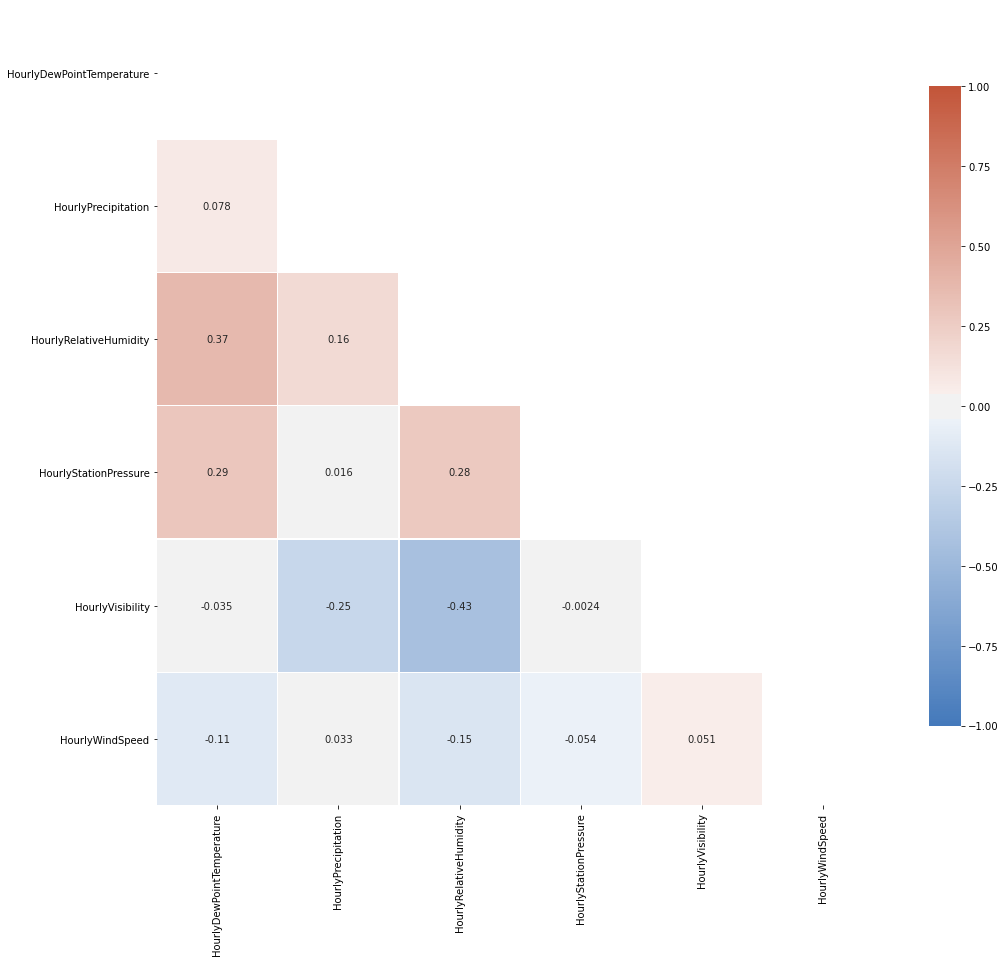

In [22]:
plot2.show()

In [23]:
print(regression_results2.vif.sort_values(ascending = True).to_string())

HourlyWindSpeed                1.030321
HourlyPrecipitation            1.078006
HourlyStationPressure          1.147038
HourlyDewPointTemperature      1.241280
HourlyVisibility               1.329884
HourlyRelativeHumidity         1.551410
const                        386.169637


## Iteration 2 Analysis

Of the remaining variables, HourlyRelativeHumidity has the most significant correlations to other variables. While it has a low P-Value and relatively low VIF, it has very high correlations to certain other IFs. The costs of these high correlations likely outweigh any value that this variable adds to the model.

# Variable Selection Iteration 3

In [24]:
plot2.close()
independent_var_list = ["HourlyDewPointTemperature", "HourlyPrecipitation", "HourlyStationPressure",
                        "HourlyVisibility", "HourlyWindSpeed"]
heat_map3, plot3 = dataframe_summary_statistics(wd_weather, independent_var_list)
regression_results3 = perform_ml_regression(wd_weather, "WeatherDelay", independent_var_list, proportion_train_data, number_of_trials)
plot3.ioff();

Trial  1 OLS; Square-Root of MSE:  15.786802549338077 ; R-Squared: 0.02729778793841764
Trial  2 OLS; Square-Root of MSE:  15.514672882881253 ; R-Squared: 0.02767949187240526
Trial  3 OLS; Square-Root of MSE:  15.941165715046884 ; R-Squared: 0.026982104490376968
Trial  4 OLS; Square-Root of MSE:  15.430632333197815 ; R-Squared: 0.02892316393300698
Trial  5 OLS; Square-Root of MSE:  15.680704699446016 ; R-Squared: 0.02322691005170252
Trial  6 OLS; Square-Root of MSE:  16.10288110662104 ; R-Squared: 0.02571377832739663
Trial  7 OLS; Square-Root of MSE:  15.701724507081488 ; R-Squared: 0.025970512784428745
Trial  8 OLS; Square-Root of MSE:  16.13683075864332 ; R-Squared: 0.024998086067319347
Trial  9 OLS; Square-Root of MSE:  16.172737203889866 ; R-Squared: 0.02827288068499545
Trial  10 OLS; Square-Root of MSE:  15.908802233130823 ; R-Squared: 0.027084344745021305


## Iteration 3 Results

### Average Square-Root of Mean-Squared-Error (MSE):

In [25]:
print("Average SQ-MSE across", number_of_trials, "trials:", statistics.mean(regression_results3.sqrt_mse_arr))

Average SQ-MSE across 10 trials: 15.837695398927659


In [26]:
print("Average R-Squared across", number_of_trials, "trials:", statistics.mean(regression_results3.r2_arr))

Average R-Squared across 10 trials: 0.026614906089507083


### Average P-Values across all trials:

In [27]:
print("Average P-Values:\n")
print(regression_results3.pval_arr.to_string())

Average P-Values:

HourlyPrecipitation           0.000000e+00
HourlyVisibility             3.000154e-299
HourlyWindSpeed              3.543136e-209
const                         1.357134e-74
HourlyDewPointTemperature     1.087499e-50
HourlyStationPressure         3.252649e-25


### Correlation plot and Variation Inflation Factors (VAF) of all Independent Variables:

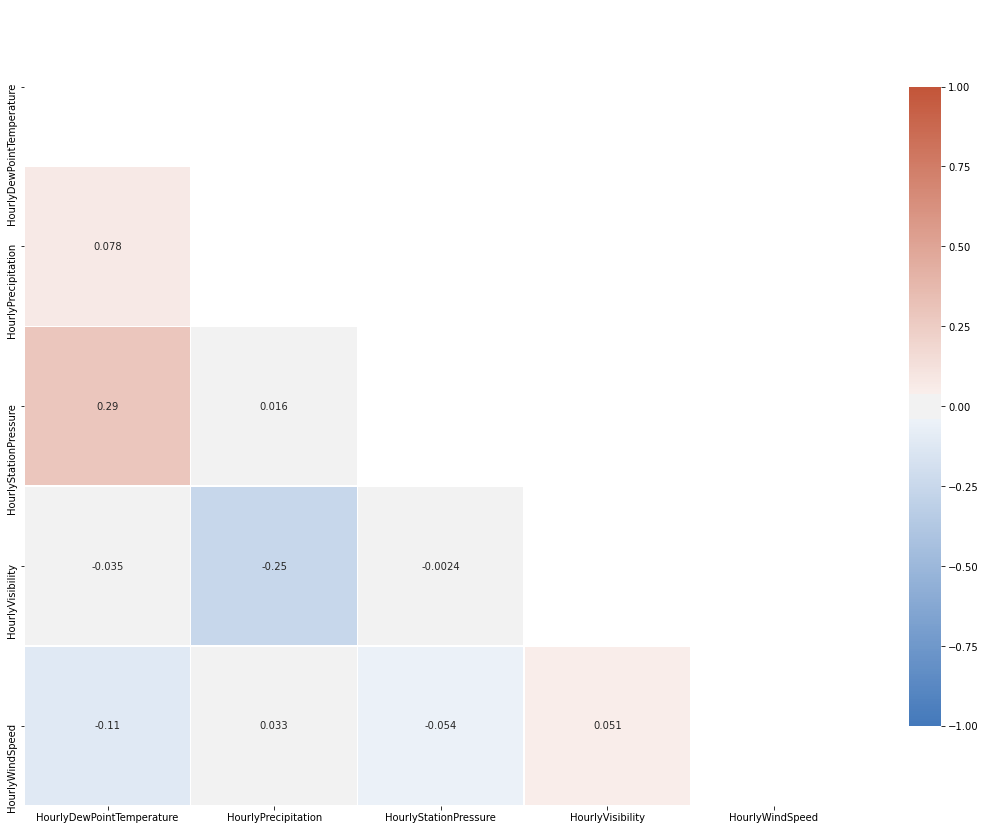

In [28]:
plot3.show()

In [29]:
print(regression_results3.vif.sort_values(ascending = True).to_string())

HourlyWindSpeed                1.019165
HourlyVisibility               1.071034
HourlyPrecipitation            1.075598
HourlyStationPressure          1.092687
HourlyDewPointTemperature      1.111056
const                        384.808606


## Iteration 3 Analysis

Since the average Square-Root of MSE and R-Squared values have not changed much across the iterations, at this point we can simply tweak the model until we find our desired selection of variables and ideal R-Square and P-Values. 

Of the remaining variables, HourlyDewPointTemperature is the only one with any significant correlations to other variables, so we can remove it. Fewer variables is usually better when constructing a model, as long as the accuracy of the model remains unchanged or improves.

# Variable Selection Iteration 4

In [30]:
plot3.close()
independent_var_list = ["HourlyPrecipitation", "HourlyWindSpeed", "HourlyVisibility", "HourlyStationPressure"]
heat_map4, plot4 = dataframe_summary_statistics(wd_weather, independent_var_list)
regression_results4 = perform_ml_regression(wd_weather, "WeatherDelay", independent_var_list, proportion_train_data, number_of_trials)
plot4.ioff();

Trial  1 OLS; Square-Root of MSE:  15.880930330629194 ; R-Squared: 0.02756469965821784
Trial  2 OLS; Square-Root of MSE:  16.03725224356897 ; R-Squared: 0.025450154325755703
Trial  3 OLS; Square-Root of MSE:  15.976048743825407 ; R-Squared: 0.023791335273649294
Trial  4 OLS; Square-Root of MSE:  16.440720816261603 ; R-Squared: 0.025041215673189177
Trial  5 OLS; Square-Root of MSE:  16.134918243598708 ; R-Squared: 0.02491252833005697
Trial  6 OLS; Square-Root of MSE:  15.941566246702978 ; R-Squared: 0.02653326944598189
Trial  7 OLS; Square-Root of MSE:  15.505081698008974 ; R-Squared: 0.027793261735587493
Trial  8 OLS; Square-Root of MSE:  16.132926158990703 ; R-Squared: 0.025723008498032107
Trial  9 OLS; Square-Root of MSE:  15.23536824834595 ; R-Squared: 0.026017157784638978
Trial  10 OLS; Square-Root of MSE:  14.792581069026044 ; R-Squared: 0.026998931957352257


## Iteration 4 Results

### Average Square-Root of Mean-Squared-Error (MSE):

In [31]:
print("Average SQ-MSE across", number_of_trials, "trials:", statistics.mean(regression_results4.sqrt_mse_arr))

Average SQ-MSE across 10 trials: 15.807739379895853


In [32]:
print("Average R-Squared across", number_of_trials, "trials:", statistics.mean(regression_results4.r2_arr))

Average R-Squared across 10 trials: 0.025982556268246172


### Average P-Values across all trials:

In [33]:
print("Average P-Values:\n")
print(regression_results4.pval_arr.to_string())

Average P-Values:

HourlyPrecipitation       0.000000e+00
HourlyVisibility         3.823092e-302
HourlyWindSpeed          3.053695e-181
const                     1.300215e-57
HourlyStationPressure     1.233015e-09


### Correlation plot and Variation Inflation Factors (VAF) of all Independent Variables:

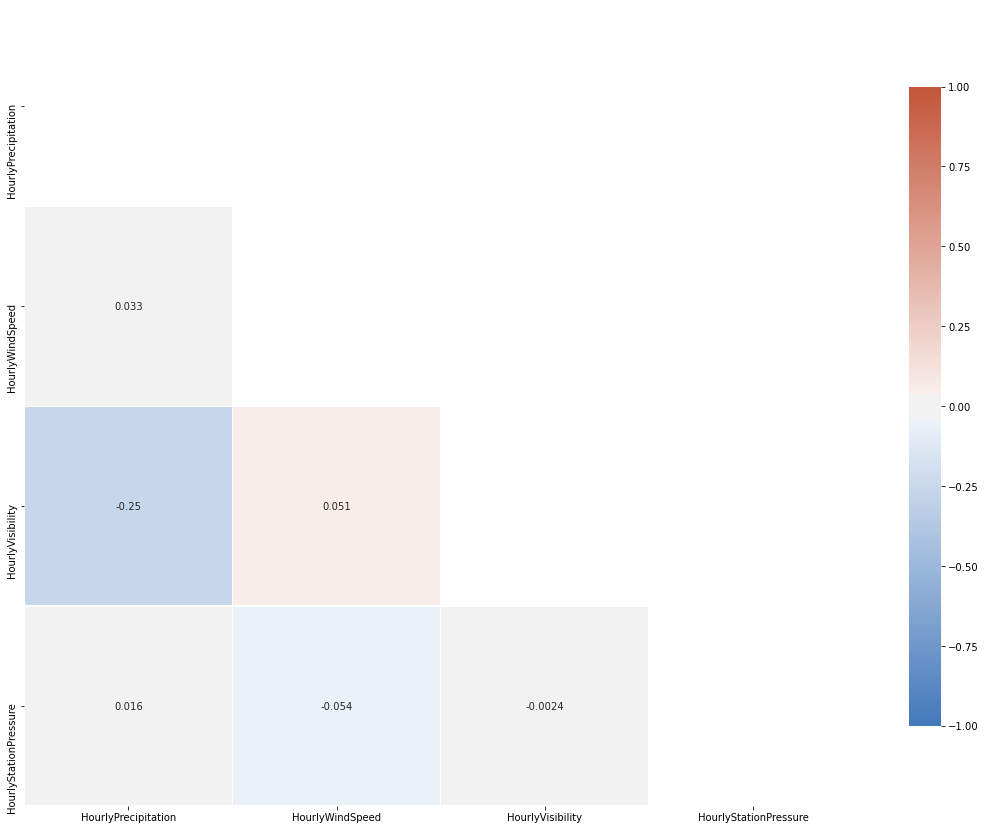

In [34]:
plot4.show()

In [35]:
print(regression_results4.vif.sort_values(ascending = True).to_string())

HourlyStationPressure      1.003287
HourlyWindSpeed            1.007899
HourlyPrecipitation        1.069558
HourlyVisibility           1.070909
const                    378.502242


## Iteration 4 Analysis

Now that we've gotten the correlation values to an acceptable level, with significant P-Values and extremely low VIFs for each variable, we can examine the coefficients to determine the effect that each individual Independent Variables has on the Dependent Variable.

### Independent Variable Coefficients

In [36]:
const_mask = regression_results4.coef.index.isin(['const'])
print(regression_results4.coef.loc[~const_mask].sort_values(ascending = False).to_string())

HourlyPrecipitation      69.748524
HourlyWindSpeed           0.078467
HourlyStationPressure    -0.059895
HourlyVisibility         -0.287497


### Intercept (Constant) Value

In [37]:
print(regression_results4.coef.loc[const_mask].to_string())

const    4.609745


The IV coefficients represent the magnitude of change to the weather delay that would, on average, occur when the value of that IV is increased by 1 unit. For example, an increase in Wind Speed of 1 MPH results in approximately 0.08 minutes (approximately 5 seconds) of additional Weather Delay, on average.

The intercept (constant) value is the baseline weather delay that would be expected to occur when all of the IVs have a value of 0. While having a positive value for this may not make sense at first, keep in mind that a value of "0" for some of the IVs isn't necessarily the "default." For example, a value of "0" for a variable like Month doesn't mean anything at all. The IV coefficients are the more interesting and useful result.

The IV coefficients combined with their respective IV values, plus the intercept, comprise the equation at the core of the linear regression model. Plugging values for each of the IVs into this equation will generate the prediction of the WeatherDelay (in minutes) for those conditions.

It is important to keep in mind that this model is nowhere near perfect. There could be any number of additional factors that impact weather delays, such as pilot experience, airline, or government regulations. 

Additionally, some of these variables may contribute to a non-linear correlation, such as an exponential or logarithmic. For example, one could reason that once you reach a certain wind speed, each additional MPH increase in wind speed cause a smaller increase in weather delays. This could potentially be represented by a logarithmic regression, or possibly a 3rd order polynomial regression. Linear regreesion may not be the best fit for every variable.

Even so, linear regression analysis can provide us with useful insights about the effects of weather on airline delays. While the predictions that result from the model may not be extremely accurate, knowing how each individual Independent Variable affects Weather Delays could prove to be useful in developing future models and experiments.